In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import datasets
from sklearn.neighbors import KernelDensity
np.random.seed(42)
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score
# Input data files are available in the read-only "../input/" directory
#import numpy as np
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from scipy.stats import norm
#For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [17]:
cancer=datasets.load_iris()
df=pd.DataFrame(cancer.data, columns=cancer.feature_names)
df["result"]=cancer.target

In [18]:
df['result'].unique()

array([0, 1, 2])

In [19]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),result
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [20]:

X=df.iloc[:,:4]
y=df.iloc[:,4]

In [21]:
y

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: result, Length: 150, dtype: int64

In [22]:
model=RandomForestClassifier(random_state=42)

In [23]:
hyperparameters = model.get_params()
hyperparameters

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [24]:
def objective(hyperparameters):
    for key, val in hyperparameters.items():
        if key in ['max_depth', 'max_leaf_nodes', 'min_samples_leaf', 'min_samples_split', 'n_estimators']:
            hyperparameters[key] = int(val)
    
    clf = RandomForestClassifier(**hyperparameters)
    
    try:
        auc = cross_val_score(clf, X, np.array(y), cv=5, scoring='accuracy')
        return -auc.mean()  # Return the negative accuracy score as we're minimizing
    except Exception as e:
        print(f"Error during cross-validation: {str(e)}")
        return float('inf')  # Return a large value (or inf) to indicate failure
    
    

The ROC AUC score is the area under the ROC curve. It sums up how well a model can produce relative scores to discriminate between positive or negative instances across all classification thresholds. The ROC AUC score ranges from 0 to 1, where 0.5 indicates random guessing, and 1 indicates perfect performance.

In [25]:
search_space={'ccp_alpha': hp.uniform('ccp_alpha',0.0,0.1),
'max_depth': hp.quniform('max_depth', 5,50,5),
 'max_leaf_nodes': hp.quniform('max_leaf_nodes', 10, 60, 10),
 'max_samples': hp.uniform('max_samples',0.0,0.1),
 'min_impurity_decrease': hp.uniform('min_impurity_decrease',0.0,0.1),
 'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
 'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
 'n_estimators': hp.quniform('n_estimators',50,1000,50)}


In [26]:
n_samples=100
sample_trials=[]
for _ in range(n_samples):
    sample_trials.append(sample(search_space))
   

In [27]:
sample_trials[0]

{'ccp_alpha': 0.009839901594212908,
 'max_depth': 10.0,
 'max_leaf_nodes': 50.0,
 'max_samples': 0.09945222849146616,
 'min_impurity_decrease': 0.045824395003917266,
 'min_samples_leaf': 8.0,
 'min_samples_split': 10.0,
 'n_estimators': 50.0}

In [28]:
n_samples

100

In [29]:
objective(sample_trials[0])

-0.3333333333333333

In [30]:
obj_score=[objective(sample_trials[i]) for i in range(len(sample_trials))]

##USING TPE ITSELF

In [31]:
dict_df={'ccp_alpha':[sample_trials[i]['ccp_alpha'] for i in range(len(sample_trials))],
 'max_depth': [sample_trials[i]['max_depth'] for i in range(len(sample_trials))],
 'max_leaf_nodes': [sample_trials[i]['max_leaf_nodes'] for i in range(len(sample_trials))],
 'max_samples': [sample_trials[i]['max_samples'] for i in range(len(sample_trials))],
 'min_impurity_decrease': [sample_trials[i]['min_impurity_decrease'] for i in range(len(sample_trials))],
 'min_samples_leaf': [sample_trials[i]['min_samples_leaf'] for i in range(len(sample_trials))],
 'min_samples_split': [sample_trials[i]['min_samples_split'] for i in range(len(sample_trials))],
 'n_estimators': [sample_trials[i]['n_estimators'] for i in range(len(sample_trials))],        
 'score':obj_score}
df_sample_trials=pd.DataFrame(dict_df)

In [32]:
df_sample_trials

,ccp_alpha,max_depth,max_leaf_nodes,max_samples,min_impurity_decrease,min_samples_leaf,min_samples_split,n_estimators,score
0,0.009840,10,50,0.099452,0.045824,8,10,50,-0.333333
1,0.069642,35,20,0.046778,0.081176,9,6,450,-0.333333
2,0.080133,45,30,0.077759,0.013368,9,9,600,-0.333333
3,0.084834,10,20,0.014781,0.003332,10,6,600,-0.333333
4,0.083287,20,10,0.055731,0.049103,8,3,700,-0.333333
...,...,...,...,...,...,...,...,...,...
95,0.080155,40,60,0.079323,0.092792,6,5,150,-0.333333
96,0.080247,35,30,0.081468,0.034371,1,7,700,-0.960000
97,0.007428,20,50,0.086613,0.077477,9,6,850,-0.333333
98,0.070842,20,50,0.069842,0.093881,10,7,100,-0.333333


In [33]:
df_sample_trials

,ccp_alpha,max_depth,max_leaf_nodes,max_samples,min_impurity_decrease,min_samples_leaf,min_samples_split,n_estimators,score
0,0.009840,10,50,0.099452,0.045824,8,10,50,-0.333333
1,0.069642,35,20,0.046778,0.081176,9,6,450,-0.333333
2,0.080133,45,30,0.077759,0.013368,9,9,600,-0.333333
3,0.084834,10,20,0.014781,0.003332,10,6,600,-0.333333
4,0.083287,20,10,0.055731,0.049103,8,3,700,-0.333333
...,...,...,...,...,...,...,...,...,...
95,0.080155,40,60,0.079323,0.092792,6,5,150,-0.333333
96,0.080247,35,30,0.081468,0.034371,1,7,700,-0.960000
97,0.007428,20,50,0.086613,0.077477,9,6,850,-0.333333
98,0.070842,20,50,0.069842,0.093881,10,7,100,-0.333333


In [34]:
def segment_distributions(trials, gamma):
    '''
    Splits samples into l(x) and g(x) distributions based on our
    quantile cutoff gamma (using rmse as criteria).
    
    Returns a kerned density estimator (KDE) for l(x) and g(x), 
    respectively.
    '''
    cut = np.quantile(trials['score'], gamma)
    l_x = trials[trials['score']<cut]
    g_x = trials[~trials.isin(l_x)].dropna()
    l_x_new=l_x.drop('score', axis=1)
    g_x_new=g_x.drop('score', axis=1)
    
    l_kde = KernelDensity(kernel='gaussian', bandwidth=5.0)
    g_kde = KernelDensity(kernel='gaussian', bandwidth=5.0)
    
    l_kde.fit(l_x_new)
    g_kde.fit(g_x_new)
    
    return l_kde, g_kde
    

In [35]:
def choose_next_hps(l_kde, g_kde, n_samples):
    '''
    Consumes KDE's for l(x) and g(x), samples n_samples from 
    l(x) and evaluates each sample with respect to g(x)/l(x).
    The sample which maximizes this quantity is returned as the
    next set of hyperparameters to test.
    '''
    samples = l_kde.sample(n_samples)
    
    l_score = l_kde.score_samples(samples)
    g_score = g_kde.score_samples(samples)
    
    hps = samples[np.argmax(g_score/l_score)]
    
    return hps

In [36]:
l_kde,g_kde=segment_distributions(df_sample_trials,0.2)


In [37]:
hps=choose_next_hps(l_kde,g_kde,20)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


In [38]:
hps

array([-2.60625074e-01,  1.29922972e+01,  5.50251106e+01, -2.11539396e+00,
        8.65417063e-01,  9.68503684e+00, -2.31999343e+00,  3.03019643e+02])

In [39]:
def algo_1(sample_trials_dataset, n_seed, n_total, gamma):
    trials = sample_trials_dataset.copy()
    for i in range(n_seed, n_total):
        
        # Segment trials into l and g distributions
        l_kde, g_kde = segment_distributions(trials, gamma)
        
        # Determine next pair of hyperparameters to test
        hps = choose_next_hps(l_kde, g_kde, 20)
        
        # Evaluate with objective
        score_gen_hps = objective({
            'ccp_alpha': hps[0],
            'max_depth': int(hps[1]),
            'max_leaf_nodes': int(hps[2]),
            'max_samples': hps[3],
            'min_impurity_decrease': hps[4],
            'min_samples_leaf': int(hps[5]),
            'min_samples_split': int(hps[6]),
            'n_estimators': int(hps[7])
        })
        
        # Ensure score_gen_hps is a 1-dimensional array
        score_gen_hps = np.array([score_gen_hps])
        
        # Concatenate hps and score_gen_hps
        result = np.concatenate([hps, score_gen_hps])
        
        # Create a DataFrame from the result and concatenate to trials
        result_df = pd.DataFrame([result], columns=trials.columns)
        trials = pd.concat([trials, result_df], ignore_index=True)
    
    return trials.iloc[n_seed:n_total]


In [40]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),result
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [41]:
n_seed=100
df= algo_1(df_sample_trials,n_seed,150,0.2)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Kerne

Error during cross-validation: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParamete

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Kerne

Error during cross-validation: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParamete

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Kerne

Error during cross-validation: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParamete

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Kerne

Error during cross-validation: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParamete

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


In [42]:
df

,ccp_alpha,max_depth,max_leaf_nodes,max_samples,min_impurity_decrease,min_samples_leaf,min_samples_split,n_estimators,score
100,2.675035,13.151860,36.642188,5.630146,-5.021680,-0.576347,5.771771,303.665316,inf
101,9.610702,9.532325,21.659205,2.552114,2.913207,-0.549116,6.219325,800.082471,inf
102,-3.383429,40.659946,31.877629,1.922142,-2.970653,-8.466062,6.131734,113.138510,inf
103,-6.181081,-6.167835,55.223244,6.582534,2.281432,4.952104,3.444450,152.645803,inf
104,1.362511,26.034498,64.805854,-1.135272,-0.808640,6.098699,8.589690,689.216665,inf
105,-4.842573,2.714501,17.788446,-0.504411,0.926154,4.990004,3.125845,805.358183,inf
106,0.256375,52.640905,42.170591,4.573029,1.217639,4.274961,7.613735,451.151721,inf
107,2.053010,48.678704,28.692712,-4.180156,7.441920,-0.419982,6.926024,250.266166,inf
108,-6.963165,29.645309,39.205001,-5.124761,-5.854434,-0.885408,0.657915,293.414994,inf
109,-2.058940,50.173485,39.429210,0.647525,-3.030450,-3.434668,8.870299,946.512925,inf


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

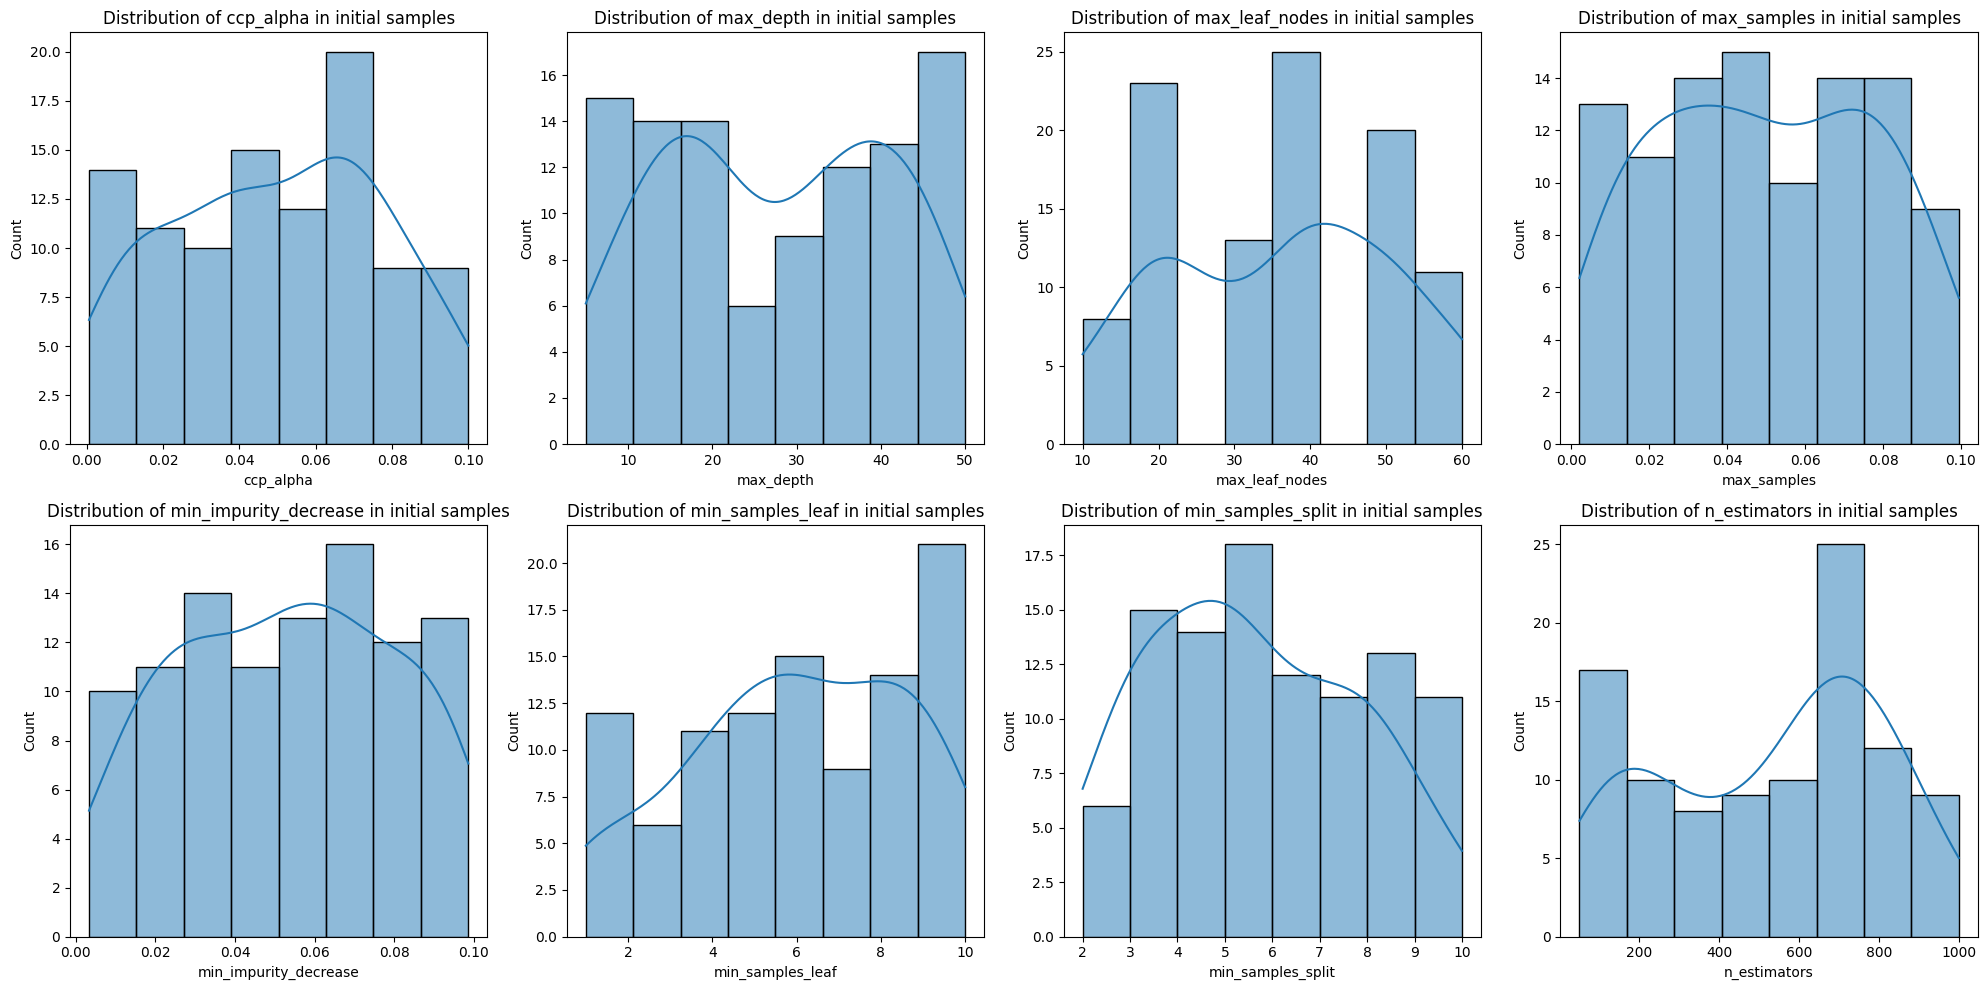

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

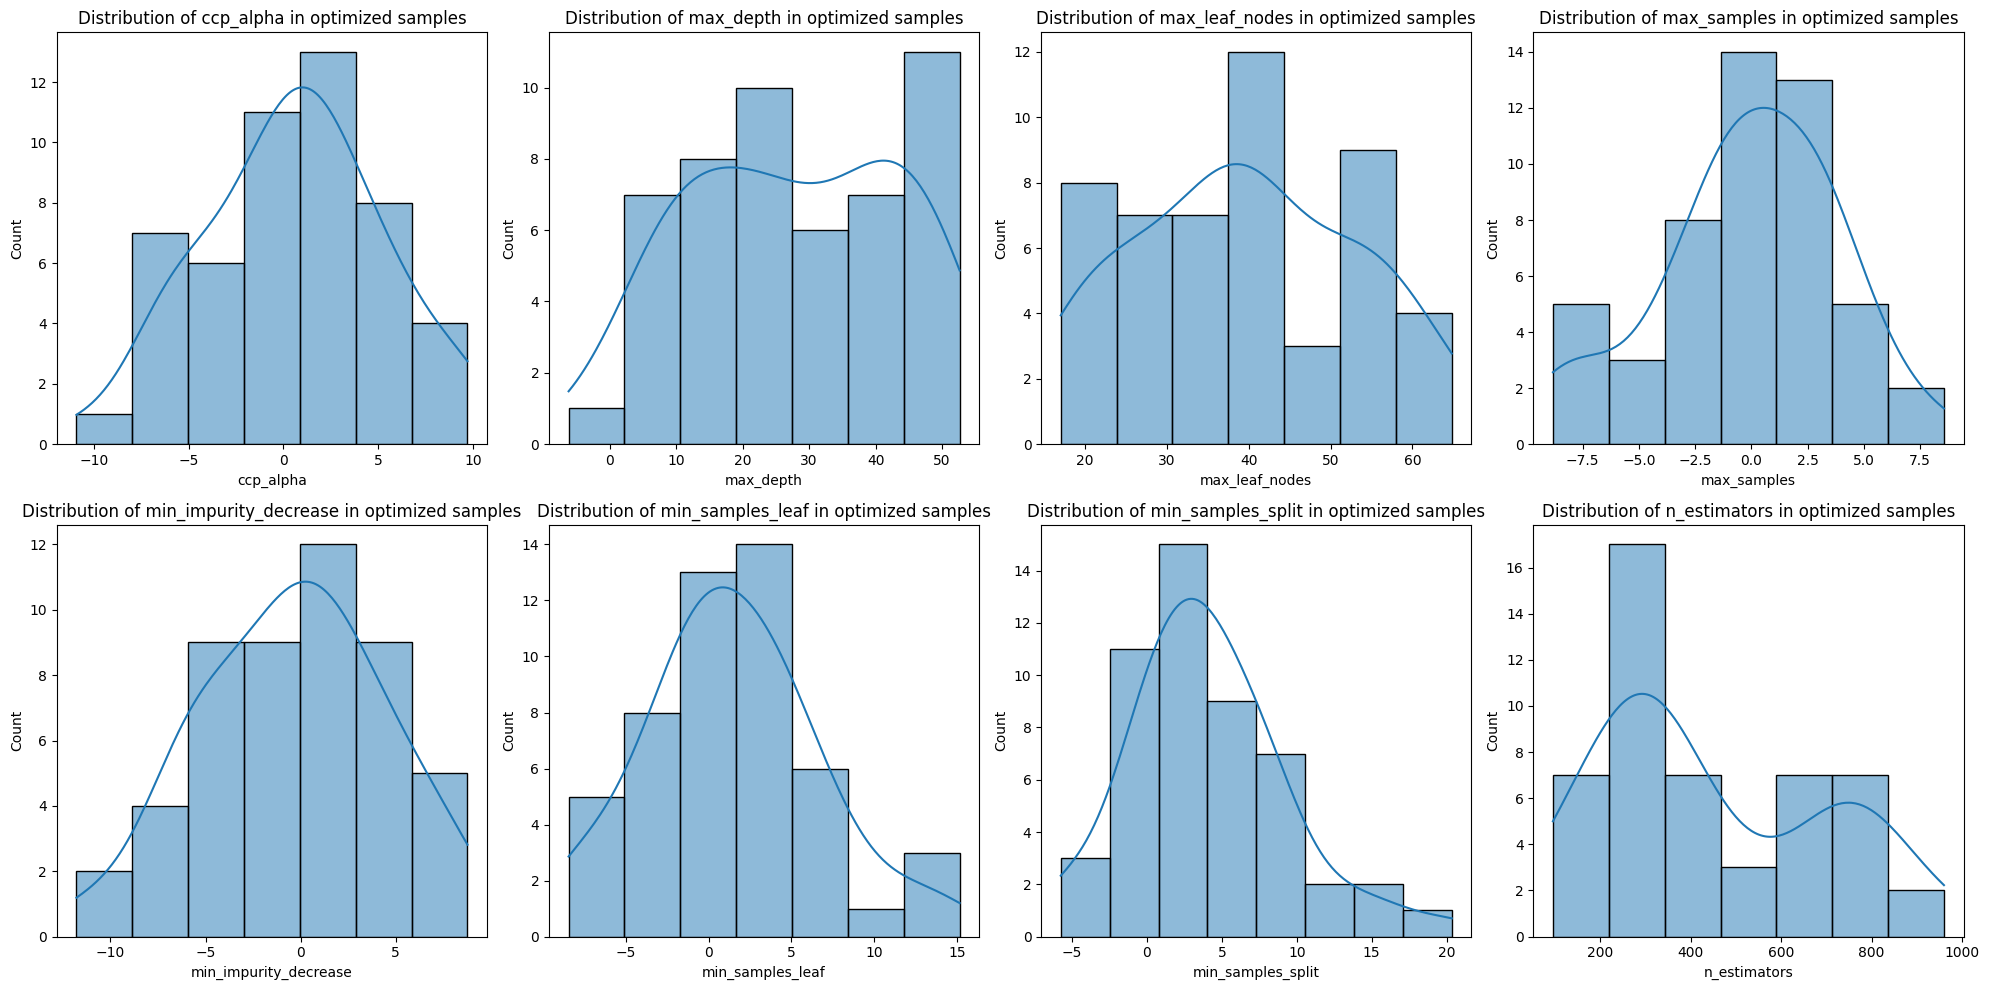

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of hyperparameters in initial samples
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, col in enumerate(df_sample_trials.columns[:-1]):  # Exclude the score column
    sns.histplot(df_sample_trials[col], ax=axes[i//4, i%4], kde=True)
    axes[i//4, i%4].set_title(f'Distribution of {col} in initial samples')

plt.tight_layout()
plt.show()

# Distribution of hyperparameters in optimized samples
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, col in enumerate(df.columns[:-1]):  # Exclude the score column
    sns.histplot(df[col], ax=axes[i//4, i%4], kde=True)
    axes[i//4, i%4].set_title(f'Distribution of {col} in optimized samples')

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

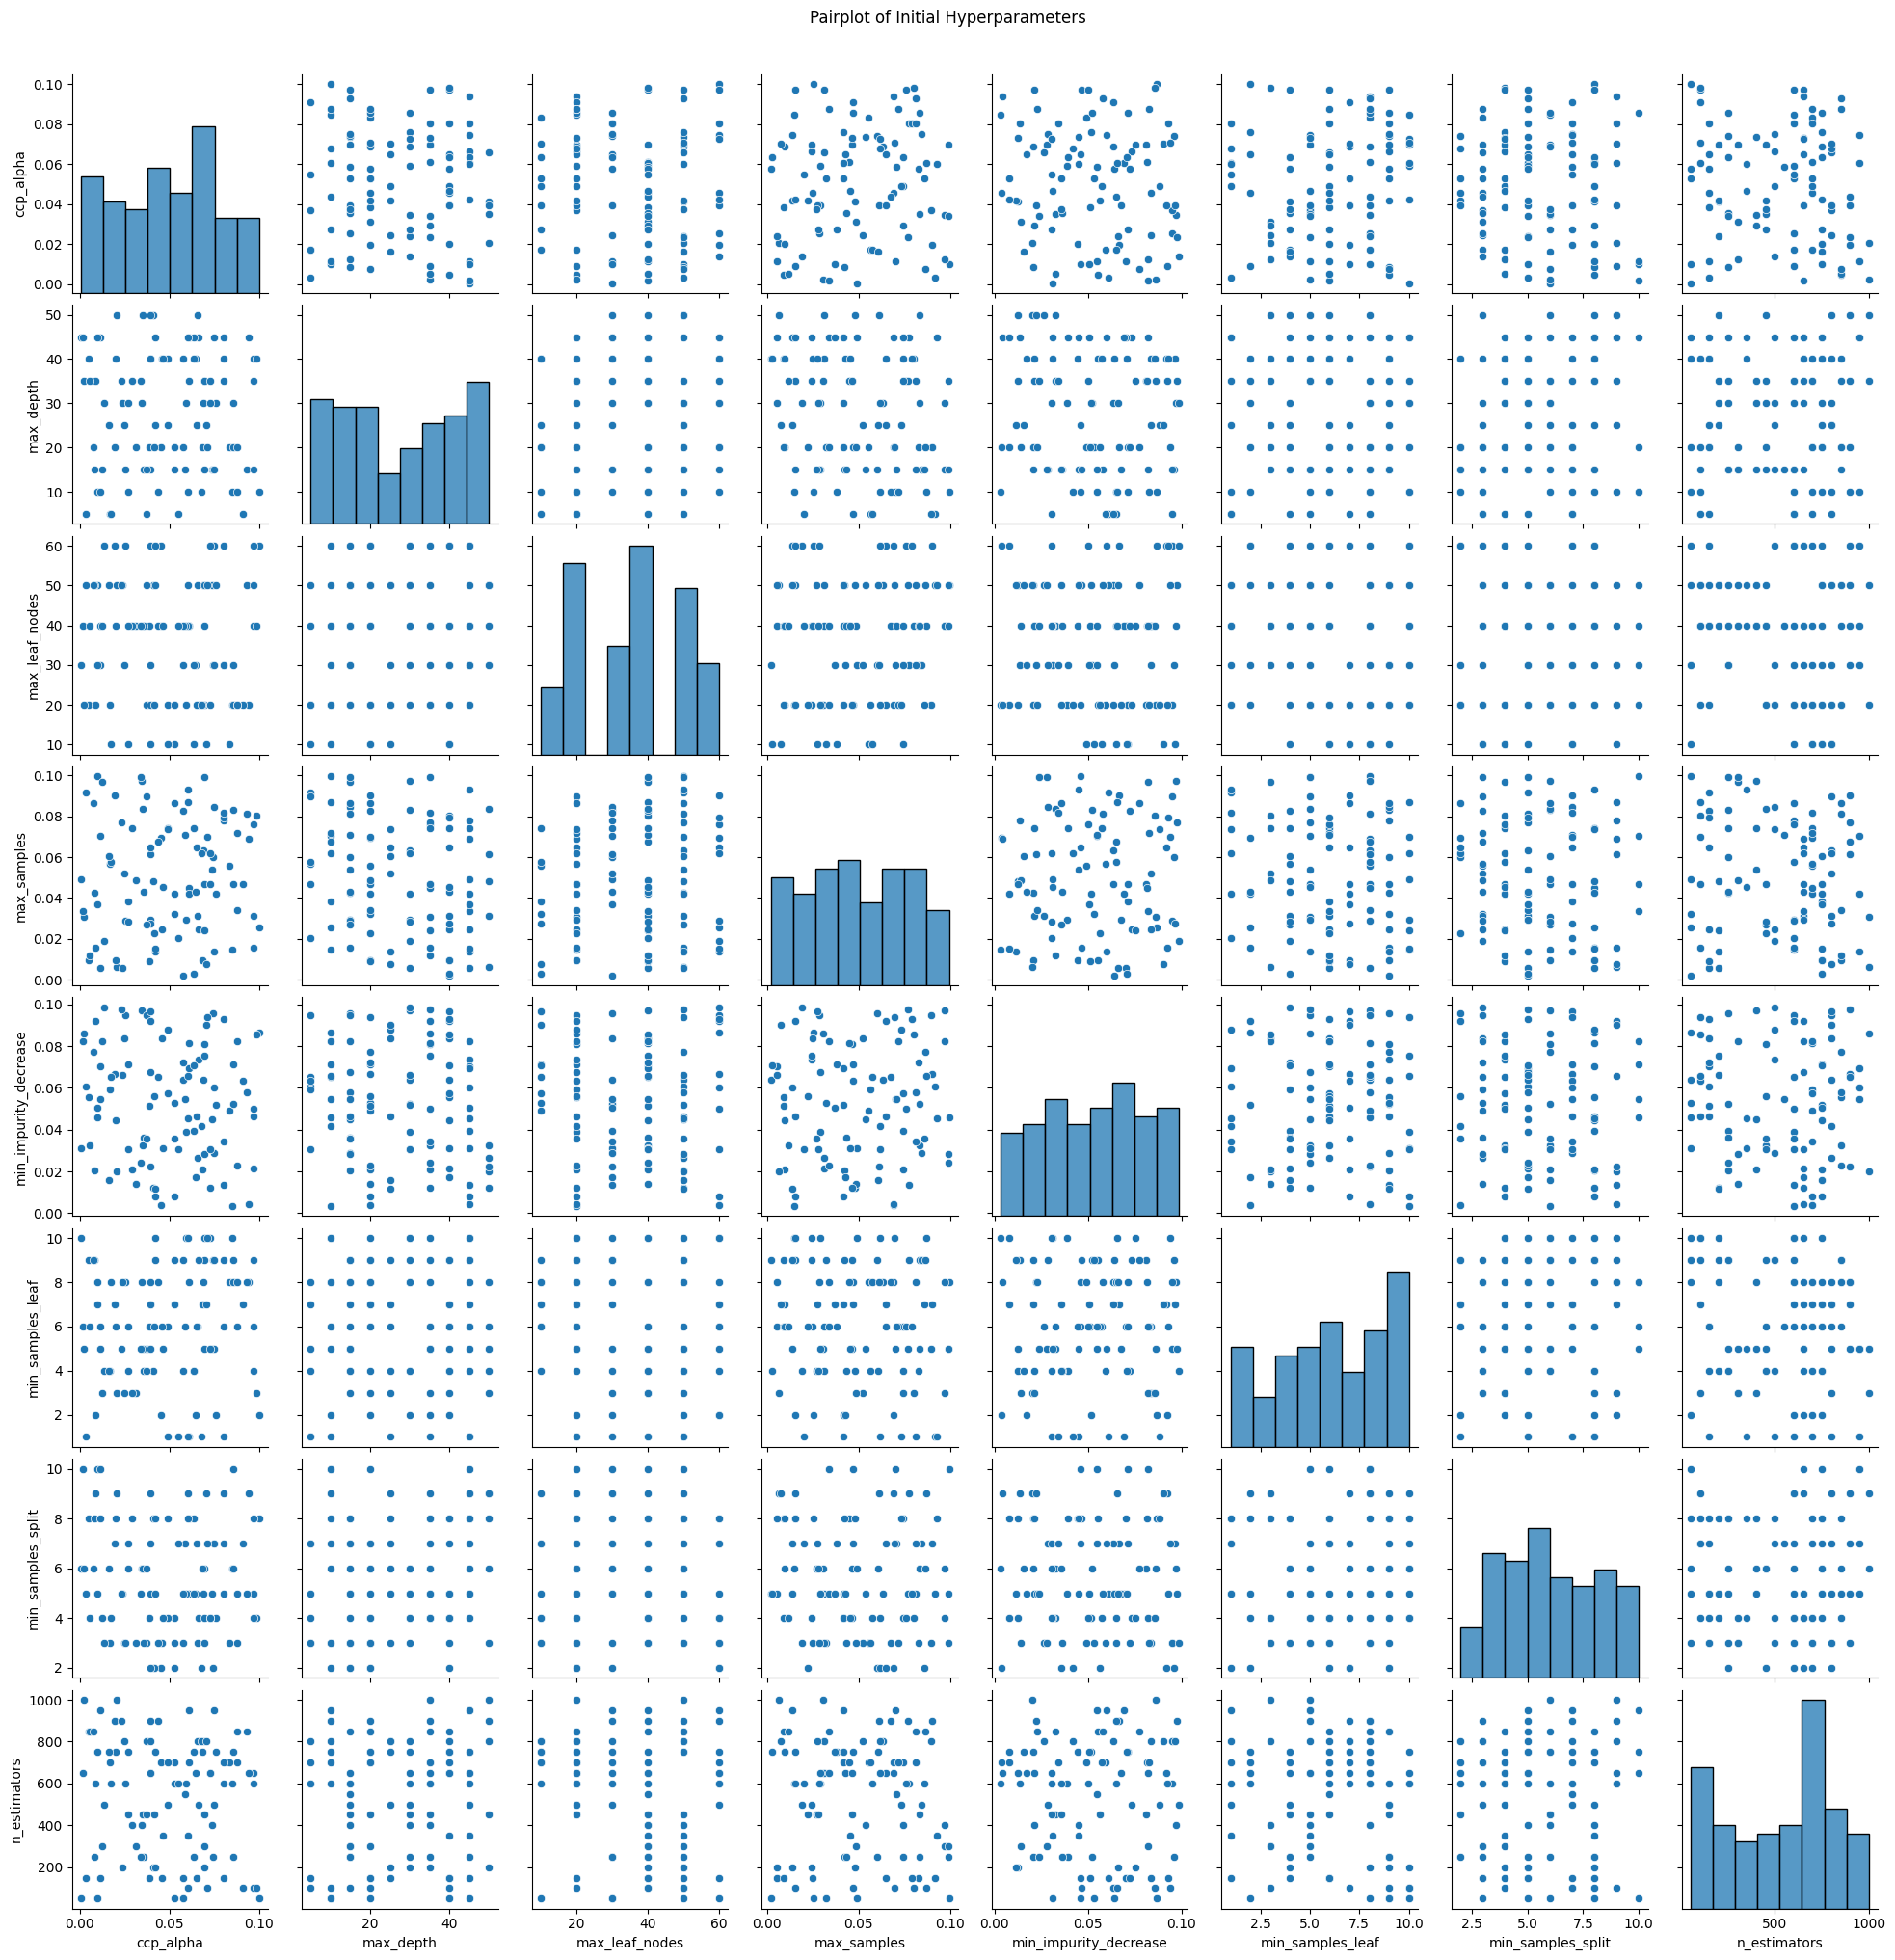

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

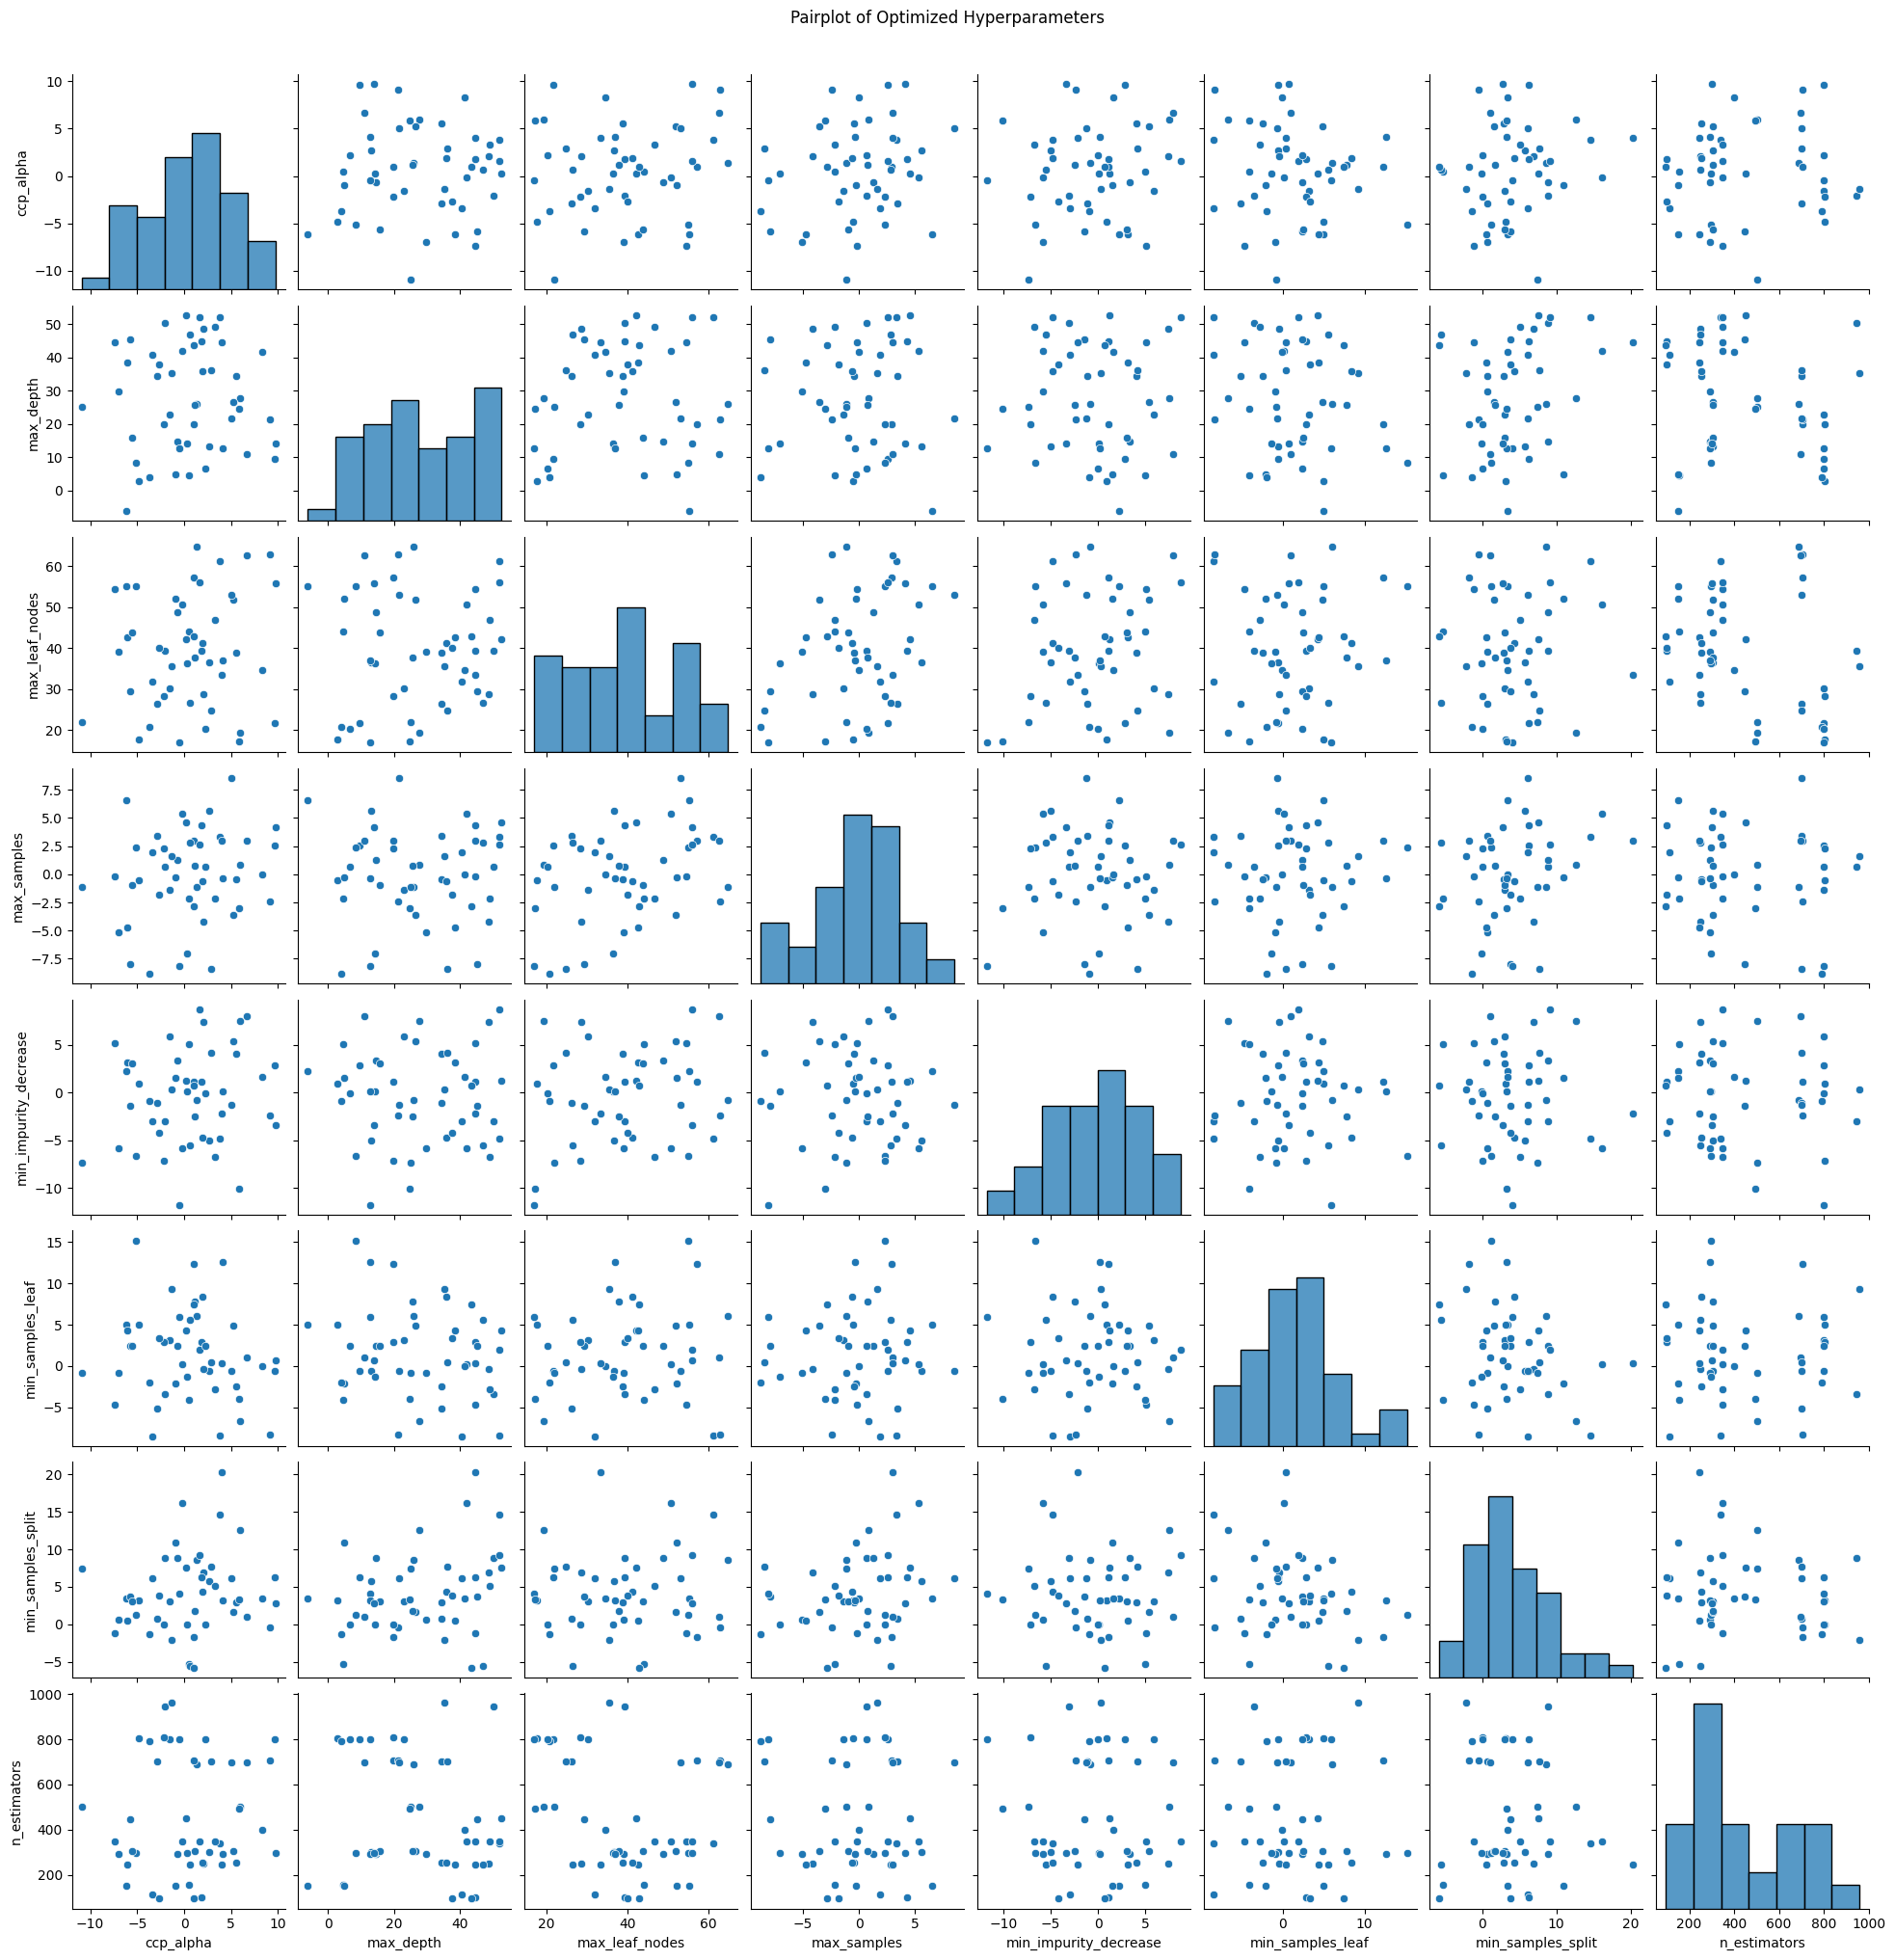

In [45]:
sns.pairplot(df_sample_trials.drop('score', axis=1))
plt.suptitle('Pairplot of Initial Hyperparameters', y=1.02)
plt.show()

sns.pairplot(df.drop('score', axis=1))
plt.suptitle('Pairplot of Optimized Hyperparameters', y=1.02)
plt.show()

/tmp/ipykernel_34/2407460398.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=df_sample_trials['max_depth'], y=df_sample_trials['n_estimators'], cmap='Blues', shade=True, bw_adjust=.5, label='Initial')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_34/2407460398.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an erro

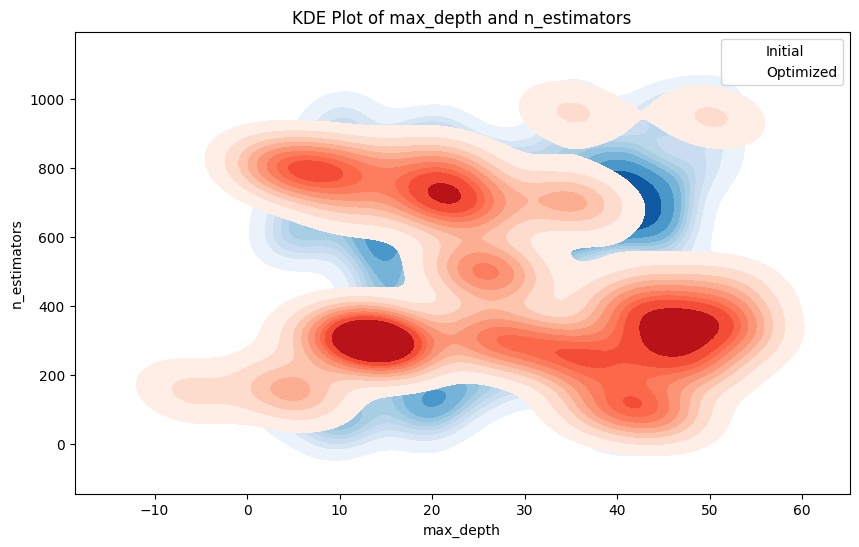

In [46]:
plt.figure(figsize=(10, 6))

# KDE plot for initial samples
sns.kdeplot(x=df_sample_trials['max_depth'], y=df_sample_trials['n_estimators'], cmap='Blues', shade=True, bw_adjust=.5, label='Initial')

# KDE plot for optimized samples
sns.kdeplot(x=df['max_depth'], y=df['n_estimators'], cmap='Reds', shade=True, bw_adjust=.5, label='Optimized')

plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.title('KDE Plot of max_depth and n_estimators')
plt.legend()
plt.show()

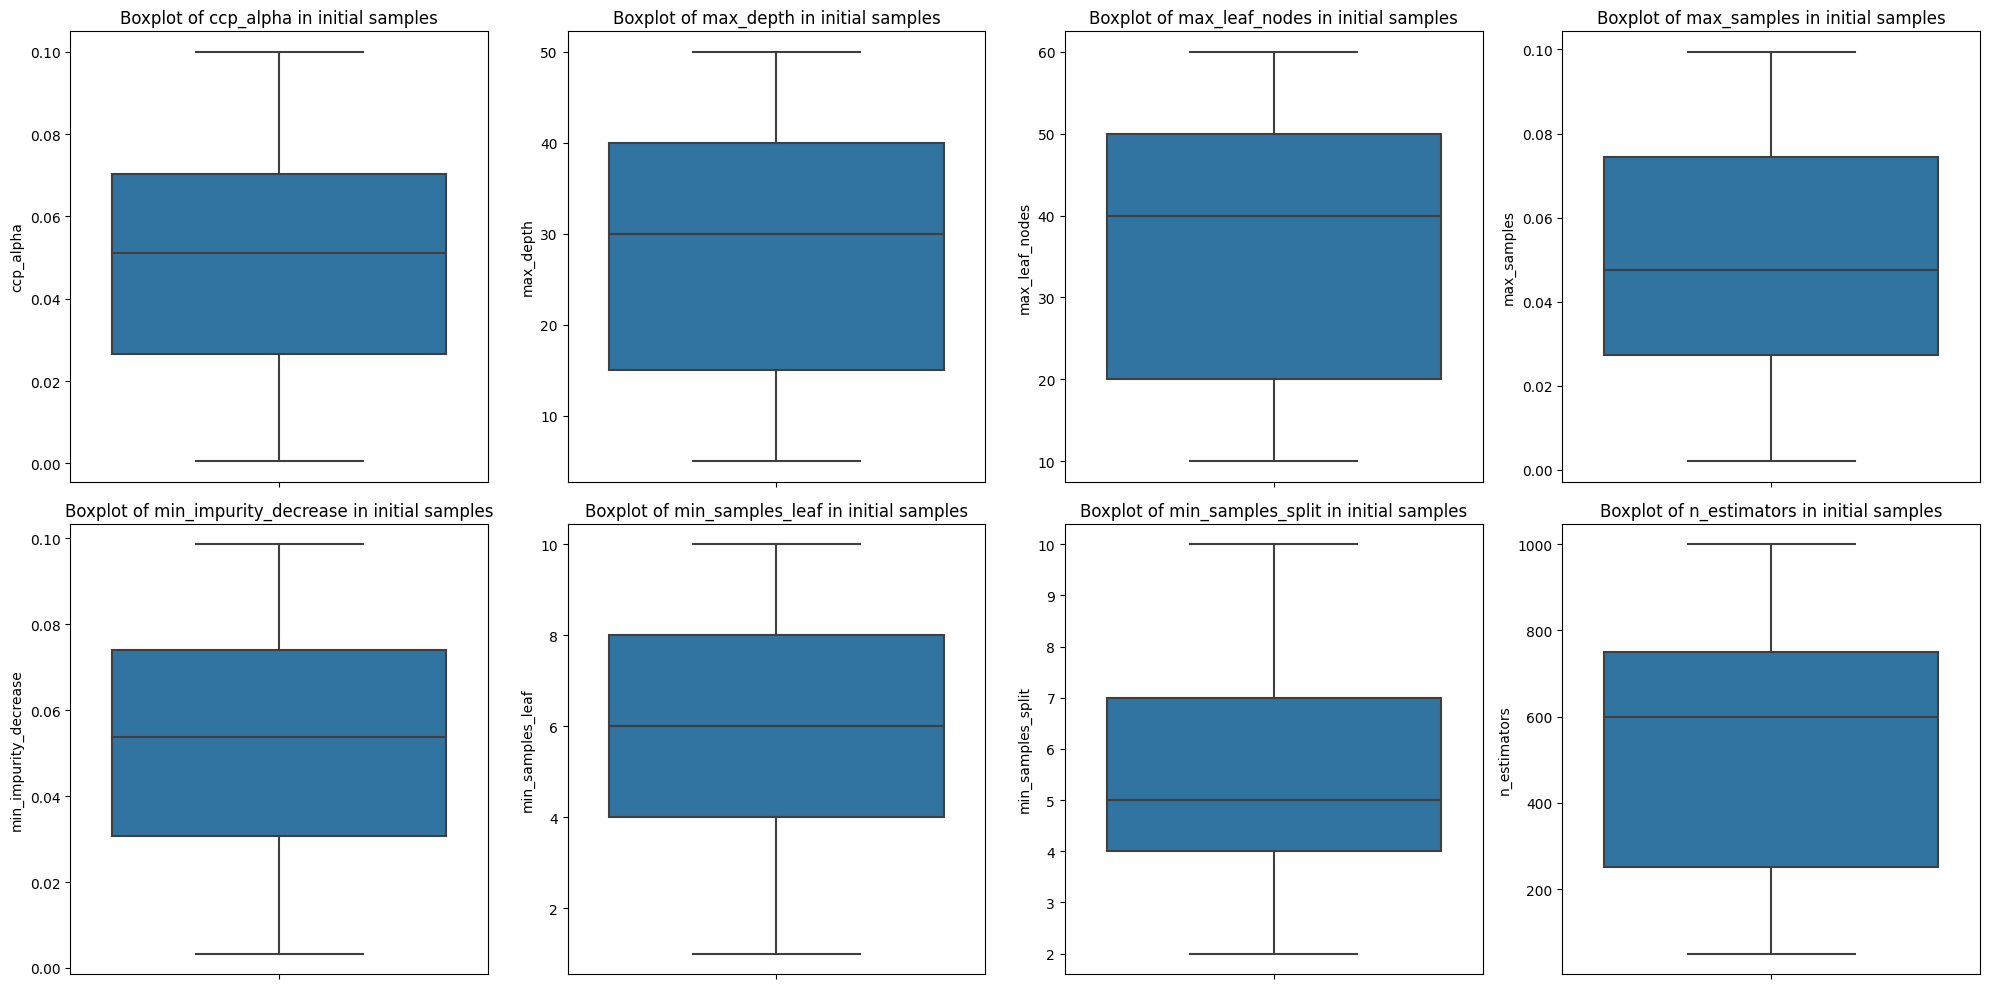

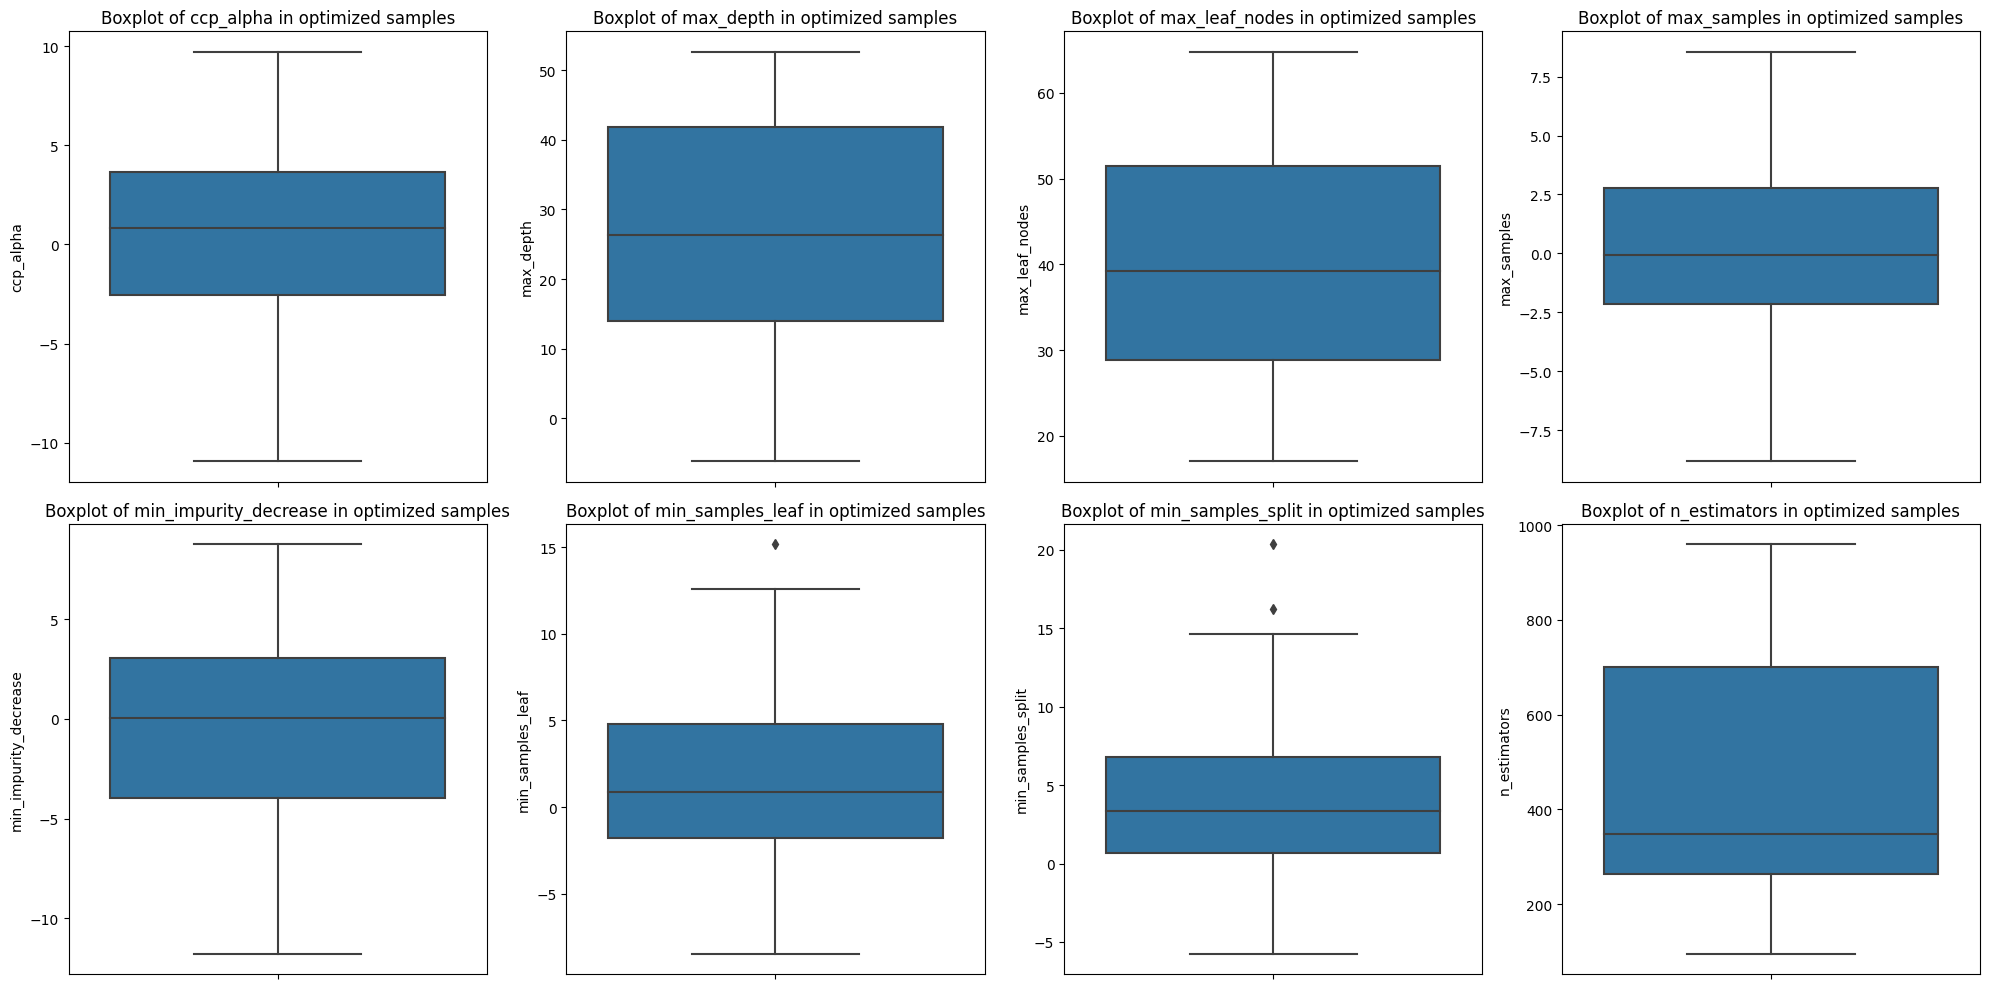

In [47]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, col in enumerate(df_sample_trials.columns[:-1]):  # Exclude the score column
    sns.boxplot(y=df_sample_trials[col], ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(f'Boxplot of {col} in initial samples')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, col in enumerate(df.columns[:-1]):  # Exclude the score column
    sns.boxplot(y=df[col], ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(f'Boxplot of {col} in optimized samples')

plt.tight_layout()
plt.show()